# CARREGAR A BASE DE DADOS (ARQUIVOS NPY)

In [ ]:
## NESTE MODELO AS CLASSES FORAM DETERMINADAS EM RANGES NÃO UNIFORMES PORÉM EM QUANTIDADES UNIFORMES

                     filename  \
0  SBBE_2015-08-08_E6_100.png   
1  SBBE_2015-08-08_E6_110.png   
2  SBBE_2015-08-08_E6_120.png   
3  SBBE_2015-08-08_E6_130.png   
4  SBBE_2015-08-08_E6_140.png   

                                               image  clusters  
0  [[[0.3764705882352941, 0.42745098039215684, 0....         3  
1  [[[0.19607843137254902, 0.24313725490196078, 0...         3  
2  [[[0.3568627450980392, 0.38823529411764707, 0....         3  
3  [[[0.28627450980392155, 0.34509803921568627, 0...         3  
4  [[[0.2823529411764706, 0.30980392156862746, 0....         3  


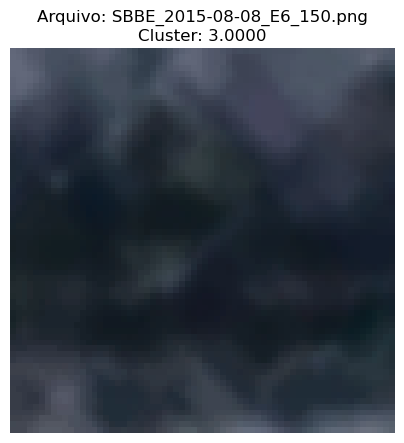

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Caminho para os arquivos .npy
images_file_path = r'C:\Users\silve\TESE\images_by_cluster_80.npy'
coefs_file_path = r'C:\Users\silve\TESE\clusters_80.npy'
filenames_file_path = r'C:\Users\silve\TESE\filenames_80.npy'  # Caminho para o arquivo com os nomes dos arquivos

# Carregar os arrays numpy dos arquivos .npy
images_array = np.load(images_file_path, allow_pickle=True)
coefs_array = np.load(coefs_file_path, allow_pickle=True)
filenames_array = np.load(filenames_file_path, allow_pickle=True)  # Carregar o array com os nomes dos arquivos

# Reconstruir o DataFrame incluindo a coluna de nomes de arquivos
df_images = pd.DataFrame({
    'filename': filenames_array,  # Adicionar os nomes dos arquivos como uma nova coluna
    'image': list(images_array),  # Converter o array de imagens para uma lista de arrays
    'clusters': coefs_array
})

# Exibir as primeiras linhas do DataFrame para confirmar a estrutura
print(df_images.head())

# Função para exibir uma imagem do DataFrame, seu coeficiente e o nome do arquivo
def display_image_and_cluster(df, index):
    # Verificar se o índice é válido
    if index < 0 or index >= len(df):
        print("Índice fora do intervalo.")
        return

    # Acessar a imagem, o coeficiente e o nome do arquivo
    image_array = df.at[index, 'image']
    cluster = df.at[index, 'clusters']
    filename = df.at[index, 'filename']

    # Configurar a figura
    plt.figure(figsize=(5, 5))

    # Exibir a imagem
    plt.imshow(image_array)
    plt.axis('off')  # Desligar os eixos para uma visualização mais clara

    # Exibir o coeficiente de cluster e o nome do arquivo como título
    plt.title(f'Arquivo: {filename}\nCluster: {cluster:.4f}', fontsize=12)

    # Mostrar a figura
    plt.show()

# Exemplo de uso da função para exibir a imagem no índice 5, seu coeficiente e o nome do arquivo
display_image_and_cluster(df_images, 5)


# CRIAÇÃO DOS GRUPOS DE TREINO, VALIDAÇÃO E TESTE

In [2]:
from sklearn.model_selection import train_test_split

# Dividir o DataFrame em conjunto de treino e teste
train_df, test_df = train_test_split(df_images, test_size=0.2, random_state=42)

# Dividir o conjunto de treino para criar o conjunto de validação
train_df, val_df = train_test_split(train_df, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2

print(f'Tamanho do conjunto de treino: {len(train_df)}')
print(f'Tamanho do conjunto de validação: {len(val_df)}')
print(f'Tamanho do conjunto de teste: {len(test_df)}')

# Função para preparar os dados, incluindo os filenames
def prepare_data(df):
    """Extrai imagens, clusters e filenames do DataFrame e os converte em arrays numpy."""
    images = np.array(list(df['image']))  # Listar e converter para array numpy
    clusters = np.array(df['clusters'])
    filenames = df['filename'].to_numpy()  # Converter a coluna de filenames para array numpy
    return images, clusters, filenames

# Preparar os dados para treino, validação e teste
X_train, y_train, filenames_train = prepare_data(train_df)
X_val, y_val, filenames_val = prepare_data(val_df)
X_test, y_test, filenames_test = prepare_data(test_df)

print(f'Forma das imagens de treino: {X_train.shape}')
print(f'Forma dos clusters de treino: {y_train.shape}')
print(f'Forma dos filenames de treino: {filenames_train.shape}')
print(f'Forma das imagens de validação: {X_val.shape}')
print(f'Forma dos clusters de validação: {y_val.shape}')
print(f'Forma dos filenames de validação: {filenames_val.shape}')
print(f'Forma das imagens de teste: {X_test.shape}')
print(f'Forma dos clusters de teste: {y_test.shape}')
print(f'Forma dos filenames de teste: {filenames_test.shape}')


Tamanho do conjunto de treino: 16425
Tamanho do conjunto de validação: 5476
Tamanho do conjunto de teste: 5476
Forma das imagens de treino: (16425, 66, 66, 3)
Forma dos clusters de treino: (16425,)
Forma dos filenames de treino: (16425,)
Forma das imagens de validação: (5476, 66, 66, 3)
Forma dos clusters de validação: (5476,)
Forma dos filenames de validação: (5476,)
Forma das imagens de teste: (5476, 66, 66, 3)
Forma dos clusters de teste: (5476,)
Forma dos filenames de teste: (5476,)


# PROCESSAMENTO DO MODELO

## OTIMIZAÇÃO DOS HIPERPARÂMETROS

In [3]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras_tuner import HyperModel, RandomSearch
import os
import shutil

class InceptionHyperModel(HyperModel):
    def __init__(self, input_shape, num_classes):
        self.input_shape = input_shape
        self.num_classes = num_classes

    def build(self, hp):
        base_model = InceptionV3(include_top=False, input_shape=self.input_shape, weights='imagenet')
        base_model.trainable = False

        inputs = Input(shape=self.input_shape)
        x = base_model(inputs, training=False)
        x = GlobalAveragePooling2D()(x)
        x = Dense(units=hp.Int('units', min_value=32, max_value=512, step=32), activation='relu')(x)
        outputs = Dense(self.num_classes, activation='softmax')(x)

        model = Model(inputs, outputs)
        model.compile(optimizer=Adam(hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')),
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])

        return model

def resize_images(images, size=(75, 75)):
    return np.array([tf.image.resize(image, size).numpy() for image in images])

X_train_resized = resize_images(X_train)
X_val_resized = resize_images(X_val)
X_test_resized = resize_images(X_test)

hypermodel = InceptionHyperModel(input_shape=(75, 75, 3), num_classes=len(np.unique(y_train)))

reset = input("Deseja resetar as informações da última rodada e iniciar uma nova otimização? (s/n): ")

tuner_dir = '13_inception_80'

if reset.lower() == 's':
    if os.path.exists(tuner_dir):
        shutil.rmtree(tuner_dir)
        print("Informações da última rodada resetadas. Iniciando nova otimização...")

tuner = RandomSearch(
    hypermodel,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1,
    directory=tuner_dir,
    project_name='inception_tuning'
)

if reset.lower() == 'n':
    # Carrega os melhores hiperparâmetros sem iniciar uma nova busca
    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
    best_model = hypermodel.build(best_hps)
    print("Modelo carregado com os melhores hiperparâmetros da última otimização.")
else:
    # Inicia uma nova busca
    tuner.search(X_train_resized, y_train, epochs=10, validation_data=(X_val_resized, y_val))
    best_model = tuner.get_best_models(num_models=1)[0]

# Avaliação do melhor modelo
best_model.evaluate(X_test_resized, y_test)


Trial 10 Complete [00h 15m 45s]
val_accuracy: 0.32870709896087646

Best val_accuracy So Far: 0.32870709896087646
Total elapsed time: 02h 38m 43s

172/172 [==============================] - 31s 133ms/step - loss: 1.3658 - accuracy: 0.3234


[1.3658455610275269, 0.3234112560749054]

## RODANDO O MODELO DE ACORDO COM OS HIPERPARÂMETROS OTIMIZADOS

In [4]:
# Obtenha os melhores hiperparâmetros
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Uma vez que a classe InceptionHyperModel já contém a lógica para construir o modelo,
# podemos reutilizar esta classe para construir o modelo com os melhores hiperparâmetros.
best_model = hypermodel.build(best_hps)

# Exibir a arquitetura do modelo
best_model.summary()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 75, 75, 3)]       0         
                                                                 
 inception_v3 (Functional)   (None, 1, 1, 2048)        21802784  
                                                                 
 global_average_pooling2d_1  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_2 (Dense)             (None, 96)                196704    
                                                                 
 dense_3 (Dense)             (None, 4)                 388       
                                                                 
Total params: 21999876 (83.92 MB)
Trainable params: 197092 (769.89 KB)
Non-trainable params: 21802784 (83.17 MB)
____________

In [5]:
from tensorflow.keras.callbacks import EarlyStopping

# Supondo que a instância hypermodel e o tuner já estejam definidos como anteriormente

# Obtenha os melhores hiperparâmetros
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Construa o modelo com os melhores hiperparâmetros usando a instância hypermodel
best_model = hypermodel.build(best_hps)

# Defina o callback de Early Stopping
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitora a perda de validação
    patience=20,         # Número de épocas sem melhoria após o qual o treinamento será interrompido
    restore_best_weights=True  # Restaura os pesos do modelo com o melhor valor de perda de validação
)

# Certifique-se de que as imagens de treino, validação e teste foram redimensionadas para o tamanho correto
X_train_resized = resize_images(X_train)
X_val_resized = resize_images(X_val)
X_test_resized = resize_images(X_test)

# Treine o melhor modelo com imagens redimensionadas
history = best_model.fit(
    X_train_resized, y_train,
    epochs=100,  # Número máximo de épocas
    validation_data=(X_val_resized, y_val),
    callbacks=[early_stopping]  # Inclui o callback de Early Stopping
)

# Avalie o melhor modelo no conjunto de teste redimensionado
test_loss, test_accuracy = best_model.evaluate(X_test_resized, y_test)
print(f"Perda no teste: {test_loss}, Acurácia no teste: {test_accuracy}")


Epoch 1/100
514/514 [==============================] - 127s 197ms/step - loss: 1.4007 - accuracy: 0.2942 - val_loss: 1.3711 - val_accuracy: 0.3033
Epoch 2/100
514/514 [==============================] - 94s 184ms/step - loss: 1.3443 - accuracy: 0.3359 - val_loss: 1.3697 - val_accuracy: 0.3104
Epoch 3/100
514/514 [==============================] - 102s 199ms/step - loss: 1.3164 - accuracy: 0.3623 - val_loss: 1.3799 - val_accuracy: 0.3114
Epoch 4/100
514/514 [==============================] - 103s 201ms/step - loss: 1.2816 - accuracy: 0.3915 - val_loss: 1.3755 - val_accuracy: 0.3110
Epoch 5/100
514/514 [==============================] - 96s 187ms/step - loss: 1.2452 - accuracy: 0.4220 - val_loss: 1.3810 - val_accuracy: 0.3203
Epoch 6/100
514/514 [==============================] - 102s 199ms/step - loss: 1.2024 - accuracy: 0.4497 - val_loss: 1.4202 - val_accuracy: 0.3181
Epoch 7/100
514/514 [==============================] - 104s 202ms/step - loss: 1.1573 - accuracy: 0.4824 - val_loss: 1.4

## INDICADORES DE PERFORMANCE DO MODELO

### PARÂMETROS NUMÉRICOS NO TESTE (PERDA, ACURÁCIA, PRECISÃO, RECALL E F1)

In [6]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import numpy as np

# Avaliar o modelo no conjunto de validação redimensionado
test_loss, test_acc = best_model.evaluate(X_val_resized, y_val, verbose=2)

# Previsões do modelo no conjunto de validação redimensionado
y_pred = best_model.predict(X_val_resized)
y_pred_classes = np.argmax(y_pred, axis=1)

# Verificar se y_val é categórico e converter para classes se necessário
if y_val.ndim > 1:
    y_true = np.argmax(y_val, axis=1)
else:
    y_true = y_val

# Matriz de confusão
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Acurácia
accuracy = accuracy_score(y_true, y_pred_classes)

# Calcular Precisão, Recall e F1 Score de forma segura para binário ou multiclasse
average_type = 'binary' if len(np.unique(y_true)) == 2 else 'macro'

# Precisão
precision = precision_score(y_true, y_pred_classes, average=average_type)

# Recall
recall = recall_score(y_true, y_pred_classes, average=average_type)

# F1 Score
f1 = f1_score(y_true, y_pred_classes, average=average_type)

# Imprimir os resultados
print(f"Perda na Validação: {test_loss}")
print(f"Acurácia na Validação: {test_acc}")
print("Matriz de Confusão:", conf_matrix, sep="\n")
print(f"Precisão: {precision}")
print(f"Recall: {recall}")
print(f"Pontuação F1: {f1}")


172/172 - 22s - loss: 1.3697 - accuracy: 0.3104 - 22s/epoch - 131ms/step
172/172 [==============================] - 31s 128ms/step
Perda na Validação: 1.3696845769882202
Acurácia na Validação: 0.3104455769062042
Matriz de Confusão:
[[271 594 132 438]
 [176 646 185 500]
 [137 445 166 466]
 [121 437 145 617]]
Precisão: 0.3146131413108961
Recall: 0.305419674235028
Pontuação F1: 0.28972033377562234


### CURVA DE APRENDIZADO PERDA E ACURÁCIA

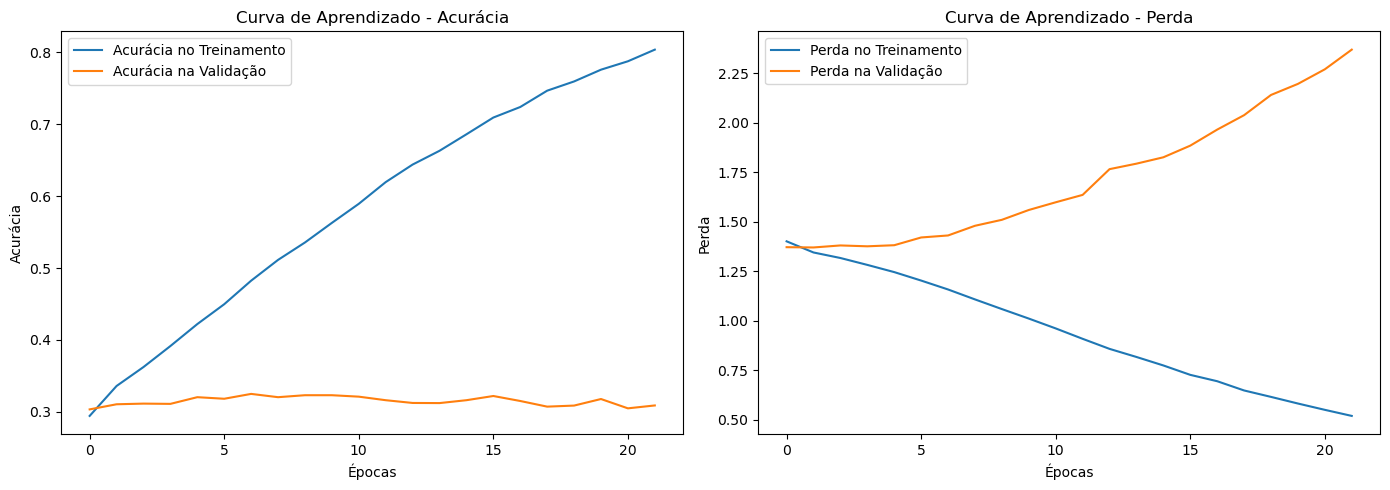

In [7]:
import matplotlib.pyplot as plt

# Supondo que 'history' seja o objeto retornado pelo método fit do seu modelo Inception otimizado

# Plotando as curvas de aprendizado
plt.figure(figsize=(14, 5))

# Acurácia
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Acurácia no Treinamento')
plt.plot(history.history['val_accuracy'], label='Acurácia na Validação')
plt.title('Curva de Aprendizado - Acurácia')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.legend()

# Perda
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Perda no Treinamento')
plt.plot(history.history['val_loss'], label='Perda na Validação')
plt.title('Curva de Aprendizado - Perda')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()

plt.tight_layout()
plt.show()


### MATRIZ DE CONFUSÃO

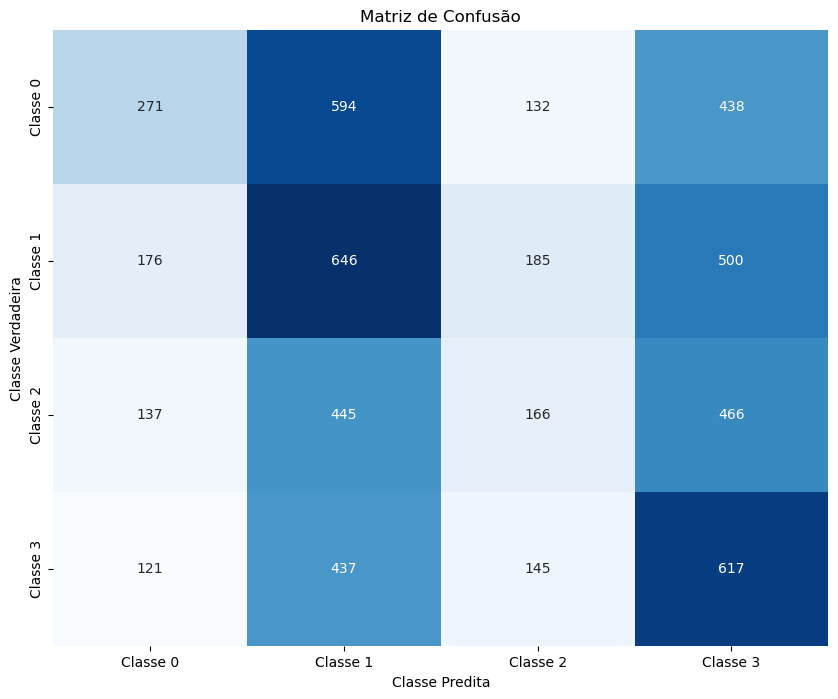

In [8]:
# MATRIZ DE CONFUSÃO

# Primeiro, instale as bibliotecas necessárias se ainda não estiverem instaladas:
# !pip install matplotlib seaborn numpy

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Insira seus dados de Matriz de Confusão aqui
confusion_mtx = conf_matrix

# Etiquetas para os eixos
axis_labels = ['Classe 0', 'Classe 1', 'Classe 2', 'Classe 3']

# Configurando o tamanho da figura
plt.figure(figsize=(10, 8))

# Criando o heatmap
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap="Blues", cbar=False, xticklabels=axis_labels, yticklabels=axis_labels)

# Adicionando o título e os rótulos dos eixos
plt.title('Matriz de Confusão')
plt.ylabel('Classe Verdadeira')
plt.xlabel('Classe Predita')

# Mostrando o gráfico
plt.show()


172/172 [==============================] - 23s 131ms/step


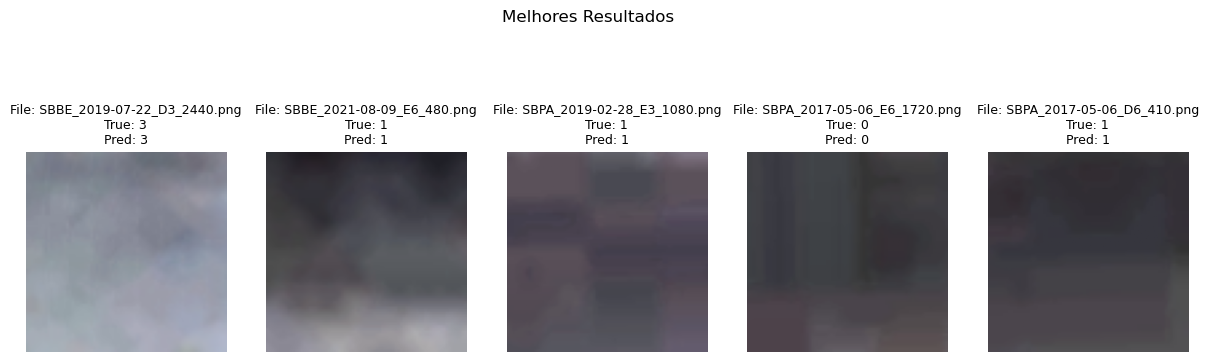

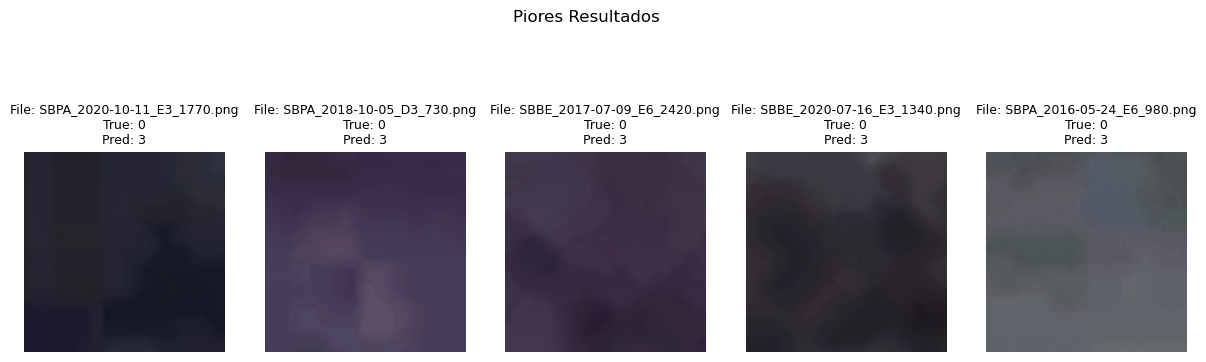

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# Supondo que 'best_model' seja o seu modelo treinado e 'X_test_resized' o seu conjunto de testes redimensionado
y_pred_probs = best_model.predict(X_test_resized)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# Calcular as perdas individuais (aqui usamos a diferença absoluta para simplificar)
losses = np.abs(y_test - y_pred_classes)

# Ordenar as perdas e obter os índices para as melhores e piores predições
sorted_indices = np.argsort(losses)
best_indices = sorted_indices[:5]  # Primeiros 5 são os de menor perda
worst_indices = sorted_indices[-5:]  # Últimos 5 são os de maior perda

# Filtrar os filenames para os melhores e piores índices
best_filenames = filenames_test[best_indices]
worst_filenames = filenames_test[worst_indices]

# Função para plotar os resultados
def plot_results(indices, images, true_labels, pred_labels, filenames, title):
    plt.figure(figsize=(15, 5))
    for i, idx in enumerate(indices):
        plt.subplot(1, len(indices), i + 1)
        plt.imshow(images[idx].squeeze(), cmap='gray')  # Ajuste o cmap conforme necessário
        plt.title(f"File: {filenames[idx]}\nTrue: {true_labels[idx]}\nPred: {pred_labels[idx]}", fontsize=9)
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

# Plotar os cinco melhores resultados com os filenames corretos
plot_results(best_indices, X_test_resized, y_test, y_pred_classes, filenames_test, "Melhores Resultados")

# Plotar os cinco piores resultados com os filenames corretos
plot_results(worst_indices, X_test_resized, y_test, y_pred_classes, filenames_test, "Piores Resultados")


## SALVANDO O MODELO

In [12]:
# Salvar o modelo no formato HDF5
best_model.save('meu_modelo_80_inception.h5')

# Salvar o modelo no formato SavedModel
best_model.save('meu_modelo_80_inception')


C:\Users\silve\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: meu_modelo_80_inception\assets


INFO:tensorflow:Assets written to: meu_modelo_80_inception\assets
